<a href="https://colab.research.google.com/github/bbary/RoadToRed/blob/main/ASM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction à la rétroingénierie de binaires [link](https://zestedesavoir.com/articles/97/introduction-a-la-retroingenierie-de-binaires/)

In [ ]:
!echo "This is a single shell command"

print ('Mixed with some Python')

In [ ]:
%%shell

echo "This is an entire cell interpreted as a shell script"
echo "You don't need to prepend each line with the '!' character"

In [ ]:
!gcc -Wall -m32 -o  test test.c

-m32 pour compiler un binaire au format 32-bit

In [ ]:
!file test

récupérer des informations sur la structure interne de ce fichier

```
test: ELF 32-bit LSB executable, Intel 80386
```








LSB : Linux Standard Base

ELF : Executable and Linkable Format est, comme son nom l’indique, un format de structuration de binaires exécutables. Ce format a notamment en charge d’indiquer la quantité de code et de données binaires à charger en mémoire, à quelle adresse, quelles sont les bibliothèques de code à charger à l’exécution du programme, etc. Sous Windows, on notera l’existence du format PE (Portable Executable) qui structure les binaires exécutables (.exe), les bibliothèques de liens dynamiques (.dll). Sous Mac, nous avons même le format mach-O

In [ ]:
%%shell
hd test | head # dumpons le début de notre fichier binaire à l’aide de l’outil hd (un alias de la commande hexdump -C)
readelf -S test # affiche les section. ELF est constitué de sections. Une section est désignée par un libellé

In [ ]:
!gcc -m32 -S test.c  # -S pour générer un fichier  test.s en langage d’assemblage, qui est le résultat de la compilation de votre fichier source.

In [ ]:
!objdump -d test --section=.text

Si on a pas le fichier source on utilise l'outil objdump. Désassemblons la section .text

# L’architecture x86

On désigne en partie, par l’architecture x86, l’ensemble des registres (petites mémoires de quelques octets directement présente à l’intérieur du processeur) et le jeu d’instructions (opcode codé sur un, deux ou trois octets ) exécutables par les processeurs de cette gamme

L’architecture x86 recense huit registres à usages généraux : eax, ebx, ecx, edx, edi, esi, ebp, esp

* eax : registre d’accumulation étendu : il est utilisé
pour stocker le résultat d’opérations arithmétiques ou les valeurs de retour des routines appelées.

* ebx : registre de base étendu : il est utilisé dans le cadre d’accès à la mémoire via l’adressage d’une donnée. Le registre de base contiendra une adresse mémoire de base, tandis que nous fournirons à côté un index, un offset, etc.

* ecx : registre de comptage étendu : il est utilisé par des opérations qui gèrent l’exécution de boucles.

* edx : registre de données étendu : il est utilisé pour stocker des données en tout genre.

* esi / edi: Les registres esi et edi sont souvent utilisés conjointement pour manipuler des données d’une source (esi) à une destination (edi), par exemple les copies.

* ebp / esp : extended base pointer / extended stack pointer. servent à délimiter ce qu’on appelle le cadre de pile courant, communément appelé stack frame

* eip : extended instruction pointer, contient l’adresse de la prochaine instruction à exécuter

les registres A,B,C,D ont pour taille 32 bits, soit 4 octets, et peuvent-être déclinés en sous-registres de 16 bits AX, BX, CX et DX qui correspondront, respectivement, à la partie inférieure des registres EAX, EBX, ECX et EDX. Enfin, ces mêmes registres de AX à DX peuvent être déclinés en deux parties:

* la partie supérieure : AH, BH, CH et DH ;
* la partie inférieure : AL, BL, CL et DL.

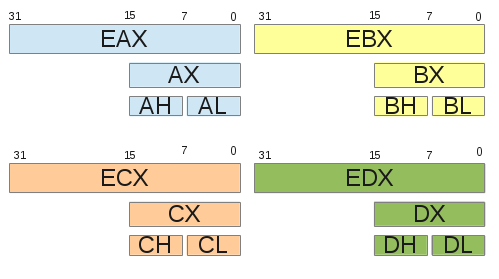

# La pile (stack) [link](https://colab.research.google.com/drive/1AXrS5kfr6yrszAf9FY4i6F2gWUFWlpXD#scrollTo=r7vYdivZjES6&line=22&uniqifier=1)

une structure de données fondée sur le principe « dernier arrivé, premier sorti » (en anglais LIFO pour last in, first out).

La plupart des microprocesseurs gèrent nativement une pile pour les appels de routine2. Elle correspond alors à une zone de la mémoire, et le processeur retient l'adresse du dernier élément.

Dans l'architecture x86 32 bits, le registre ESP sert à indiquer l'adresse du sommet d'une pile dans la mémoire vive3. Les opcodes push et pop permettent respectivement d'empiler et de dépiler des données

Dans la plupart des langages de programmation compilés, la pile d'exécution est l'endroit où sont empilés tout ou partie des paramètres d'appel des routines. Par ailleurs, on y crée un espace pour des variables locales. La pile est ainsi formée de cadres de piles (en anglais stack frames) comprenant pour chaque routine, en cours d'appel imbriqué, ses paramètres, ses variables locales et son point de retour.

Au fur et à mesure que l’on appelle des fonctions et alloue de la mémoire statiquement (à ne surtout pas confondre avec le mot-clé static en C, car ici je parle des variables locales, entendons-nous bien) au sein d’une fonction, la pile est amenée à grandir. Dans l’architecture x86, elle grandit vers les adresses basses, ce qui veut dire que plus nous allouons de la mémoire, plus la valeur du registre esp décroit. Ainsi, esp aura une valeur toujours inférieure au registre ebp (normalement…).
